In [64]:
import string
import re
import warnings
import requests
from multiprocess import Process, Manager
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = 40

In [65]:
articles = pd.read_csv(
    './data/articles_prep.csv', 
    delimiter=';'
)
articles = articles.dropna(
    subset=['time_stamp', 'company', 'title', 'text']
).sample(
    frac=1
)#.head(1000).reset_index(drop=True)

display(articles)

punctuation = string.punctuation
punctuation += '•€'

stop_words = stopwords.words('english')

,company,time_stamp,title,length,text
15052,encavis ag,2022-05-02,DGAP-News: ENCAVIS AG: Preliminary Key Perform...,805.0,DGAP-News: ENCAVIS AG / Key word(s): Quarter R...
18684,lanxess ag,2018-05-22,DGAP-Public Voting Rights: LANXESS Aktiengesel...,829.0,LANXESS Aktiengesellschaft: Release according ...
15295,bechtle ag,2022-09-07,Quarterly Report Analysis Q2 2022: Bechtle rep...,1305.0,"GERMAN RESULTS Bechtle (ETR:BC8), announced ne..."
14393,commerzbank ag,2019-11-28,Commerzbank AG Post-stab Rentenbank 0% EUR 1bn...,257.0,TIDMCZB Post-stabilisation notice 28 November ...
7893,rheinmetall ag,2019-07-24,Personnel Change at the Rheinmetall Group,347.0,Rheinmetall Group issued the following news re...
...,...,...,...,...,...
16014,aurubis ag,2022-05-04,DGAP-News: Aurubis AG: Investment in the futur...,1266.0,Aurubis AG: Investment in the future: major pl...
43,sma solar technology ag,2019-11-06,-SMA Solar Academy Expands Its Worldwide Train...,578.0,SMA Solar Academy Expands Its Worldwide Traini...
13239,dic asset ag,2022-08-24,DGAP-News: DIC Asset AG: Start of construction...,847.0,DGAP-News: DIC Asset AG / Key word(s): Real Es...
726,wacker neuson se,2021-04-09,DGAP-CMS: Wacker Neuson SE: Release of a capit...,399.0,DGAP Post-admission Duties announcement: Wacke...


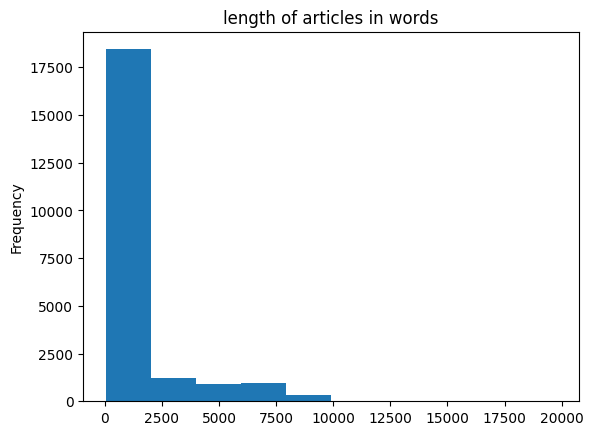

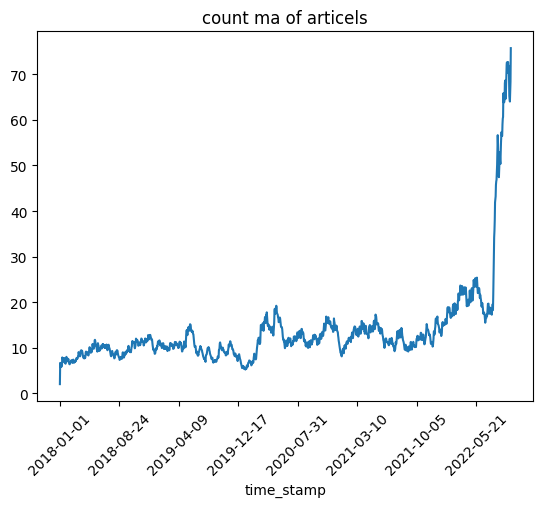

In [66]:
articles['length'].plot(
    kind='hist',
    title='length of articles in words'
)
plt.show()
"""
articles_string = articles['text'].to_list()
articles_string = ' '.join(articles_string)
articles_string = articles_string.lower()
articles_string = articles_string.translate(str.maketrans('', '', punctuation))
articles_string = ' '.join(articles_string.split())

wordcloud = WordCloud(width=2000, height=1000)
wordcloud.generate(articles_string)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
"""
articles.groupby('time_stamp')['text'].count().ewm(halflife=10).mean().plot(
    kind='line',
    title='count ma of articels'
)
plt.xticks(rotation = 45)
plt.show()

In [67]:
%%time
lemmatizer = WordNetLemmatizer()

def map_postag(word):
    if word == 'NOUN':
        return 'n'
    elif word == 'VERB':
        return 'v'
    elif word == 'ADJ':
        return 'a'
    elif word == 'ADV':
        return 'r'
    else:
        return 'n'

def preprocessor(X):
    # to lower
    X = X.lower()
    # punctuation
    X = X.translate(str.maketrans('', '', punctuation))
    # remove multi white space
    X = ' '.join(X.split())
    
    return X

def tokenizer(X):
    # tokenize
    X = word_tokenize(X, language='english')
    # pos tag
    X = pos_tag(X, tagset='universal')
    X = [(s[0], map_postag(s[1])) for s in X]
    # remove strange words
    q = [r'(.)\1\1', r'\d', 'www', 'http']
    X = [s for s in X if not any([bool(re.search(x, s[0])) for x in q])]
    X = [s for s in X if len(s[0]) < 20]
    # stopwords
    X = [s for s in X if len(s[0]) > 2]
    X = [s for s in X if not s[0] in stop_words]
    # lemmatize
    X = [lemmatizer.lemmatize(s[0], pos=s[1]) for s in X]
    
    return X

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    max_df=0.25,
    min_df=2,
    #ngram_range=(1,3)
)

X = vectorizer.fit_transform(articles['text'])
tokens = articles['text'].apply(vectorizer.build_analyzer()).to_list()

print(f'n_articels: {X.shape[0]}')
print(f'n_features (words/ngrams): {X.shape[1]}')

n_articels: 21890
n_features (words/ngrams): 50348
CPU times: user 30min 53s, sys: 4.53 s, total: 30min 57s
Wall time: 30min 58s


In [68]:
%%time
def compute_coherence(topic_coherence, t):
    # train lda
    lda = LatentDirichletAllocation(
        n_components=t,
        doc_topic_prior=None,
        topic_word_prior=None,
        learning_method='online',
    )
    lda.fit(X)
    
    # compute coherence score
    coherence = metric_coherence_gensim(
        measure='c_v',
        top_n=25,
        topic_word_distrib=lda.components_,
        vocab=vectorizer.get_feature_names_out(),
        dtm=X,
        texts=tokens,
        return_mean=True
    )
    
    # append to shared list
    topic_coherence.append([t, coherence])
    
# test hyper params
with Manager() as manager:
    topic_coherence = manager.list()
    processes = []
    max_topics = 15
    for t in range(1, max_topics):
        p = Process(target=compute_coherence, args=(topic_coherence, t))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        
    topic_coherence = list(topic_coherence)

topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence_score'])

CPU times: user 48.2 ms, sys: 139 ms, total: 188 ms
Wall time: 14min 29s


<AxesSubplot:xlabel='n_topics'>

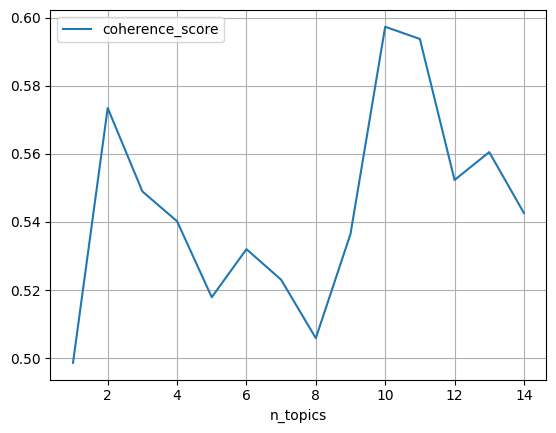

In [70]:
topic_coherence.sort_values('n_topics').plot(x='n_topics', y='coherence_score', grid=True)

In [71]:
%%time
lda_model = LatentDirichletAllocation(
    n_components=10,
    doc_topic_prior=None,
    topic_word_prior=None,
    learning_method='online',
)
lda_model.fit(X)

CPU times: user 8min 44s, sys: 3min 35s, total: 12min 19s
Wall time: 1min 35s


LatentDirichletAllocation(learning_method='online')

In [73]:
#pyLDAvis.sklearn.prepare(lda_model, X, vectorizer)

In [74]:
# prepare doc topic distribution
doc_topic = lda_model.transform(X)
doc_topic = pd.DataFrame(
    doc_topic,
    columns=[f'topic_{i}' for i in range(1, doc_topic.shape[1]+1)]
)
display(doc_topic)

# calculate topic distribution
topic_size = (doc_topic.sum() / len(doc_topic)).to_frame().transpose()
display(topic_size)

# prepare topic word distribution
topic_word = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
topic_word = pd.DataFrame(
    topic_word,
    index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
    columns=vectorizer.get_feature_names_out()
).round(5)

# display topics
for topic in topic_word.index:
    display(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :10])

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.362393,0.000439,0.000439,0.028983,0.000439,0.000439,0.000439,0.000439,0.080164,0.525828
1,0.000565,0.994915,0.000565,0.000565,0.000565,0.000565,0.000565,0.000565,0.000565,0.000565
2,0.000241,0.000241,0.000241,0.901416,0.000241,0.000241,0.055163,0.000241,0.000241,0.041734
3,0.985936,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563
4,0.000827,0.000827,0.146494,0.000827,0.440976,0.000827,0.000827,0.000826,0.000827,0.406744
...,...,...,...,...,...,...,...,...,...,...
21885,0.026480,0.003318,0.017269,0.000233,0.000233,0.508031,0.005546,0.000233,0.000233,0.438424
21886,0.000415,0.000415,0.000415,0.000415,0.336992,0.053268,0.000415,0.000415,0.066232,0.541018
21887,0.000317,0.000317,0.000317,0.098016,0.000317,0.000317,0.000317,0.000316,0.329810,0.569959
21888,0.223763,0.100717,0.000901,0.000901,0.000901,0.000901,0.000901,0.000901,0.614046,0.056069


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.165361,0.087554,0.039539,0.094262,0.039672,0.126914,0.044712,0.021278,0.181395,0.199313


,percent,quarter,ebitda,euro,earnings,margin,ebit,net,adjust,figure
topic_1,0.01559,0.0147,0.01094,0.01072,0.00944,0.00937,0.00854,0.00759,0.00697,0.00694


,right,vote,sec,wphg,voting,instrument,notification,person,meeting,control
topic_2,0.08578,0.04808,0.04736,0.04729,0.04194,0.03776,0.0321,0.02268,0.01471,0.01435


,supervisory,member,metro,chairman,meditec,since,zeiss,officer,committee,chief
topic_3,0.01762,0.01621,0.01592,0.01211,0.01093,0.01038,0.00905,0.00759,0.00755,0.00709


,asset,net,average,profit,past,yield,rank,dividend,sector,return
topic_4,0.02731,0.02013,0.01696,0.01694,0.01608,0.01503,0.01381,0.01277,0.01206,0.01169


,rheinmetall,kion,yield,dividend,adr,rank,gmbh,low,truck,hella
topic_5,0.01759,0.01548,0.01495,0.01278,0.01252,0.01032,0.01024,0.00842,0.00833,0.00823


,analysis,forecast,research,lanxess,size,chemical,inc,trend,player,region
topic_6,0.01307,0.01233,0.00967,0.00891,0.00823,0.00784,0.00648,0.00618,0.00556,0.00554


,past,average,rank,ago,sector,month,relative,return,dividend,top
topic_7,0.02198,0.01698,0.0162,0.01478,0.01404,0.01323,0.01144,0.0114,0.01025,0.00992


,blackrock,inc,holdco,holding,limit,cayman,llc,west,bay,jersey
topic_8,0.22204,0.10809,0.06442,0.0595,0.05897,0.03586,0.02728,0.02483,0.0239,0.02276


,patent,person,morphosys,transaction,publication,relate,forwardlooking,regulation,schaeffler,property
topic_9,0.01241,0.00839,0.00824,0.00687,0.00675,0.00661,0.00602,0.00593,0.00525,0.00471


,solution,software,energy,say,partner,sixt,portfolio,project,production,evotec
topic_10,0.00563,0.0055,0.00537,0.00478,0.00413,0.00393,0.0037,0.00367,0.00342,0.00333


In [75]:
topic_activity = doc_topic.copy()

# clip news on weekend to friday
topic_activity['time_stamp'] = pd.to_datetime(articles['time_stamp'])
topic_activity['time_stamp'] -= pd.to_timedelta((topic_activity['time_stamp'].dt.dayofweek - 4).clip(lower=0), unit='D')

# sum up news by date and company
topic_activity['time_stamp'] = topic_activity['time_stamp'].dt.date
topic_activity['company'] = articles['company']
topic_activity = topic_activity.groupby(['company', 'time_stamp']).apply(lambda x: x.sum()/len(x))

# insert 0 for days with no news
topic_activity = topic_activity.unstack(fill_value=0, level=0)
topic_activity.index = pd.to_datetime(topic_activity.index)
topic_activity = topic_activity.asfreq('D', fill_value=0)
topic_activity = topic_activity.stack(level=1)
topic_activity = topic_activity.swaplevel().sort_index()

# drop weekends
topic_activity = topic_activity[topic_activity.index.get_level_values('time_stamp').dayofweek < 5]

# compute moving average
topic_activity = topic_activity.ewm(halflife=5).mean()
display(topic_activity)

# safe to csv
topic_activity.to_csv('data/topic_activity.csv', sep=';')

topic_1       topic_2       topic_3  \
company          time_stamp                                             
1&1 drillisch ag 2018-01-01  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-02  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-03  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-04  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-05  0.000000e+00  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
zooplus ag       2022-09-26  4.473112e-15  1.981847e-15  1.805409e-16   
                 2022-09-27  3.894070e-15  1.725298e-15  1.571700e-16   
                 2022-09-28  3.389985e-15  1.501959e-15  1.368244e-16   
                 2022-09-29  2.951153e-15  1.307531e-15  1.191126e-16   
                 2022-09-30  2.569128e-15  1.138272e-15  1.036935e-16   

                                  topic_4       topic_5       topic_6  \
company          time_stamp                                             
1&1 drillisch ag 2018-01-01  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-02  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-03  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-04  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-05  0.000000e+00  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
zooplus ag       2022-09-26  1.444523e-16  9.404740e-15  3.788439e-15   
                 2022-09-27  1.257530e-16  8.187302e-15  3.298028e-15   
                 2022-09-28  1.094744e-16  7.127460e-15  2.871100e-15   
                 2022-09-29  9.530296e-17  6.204814e-15  2.499438e-15   
                 2022-09-30  8.296605e-17  5.401605e-15  2.175887e-15   

                                  topic_7       topic_8       topic_9  \
company          time_stamp                                             
1&1 drillisch ag 2018-01-01  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-02  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-03  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-04  0.000000e+00  0.000000e+00  0.000000e+00   
                 2018-01-05  0.000000e+00  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
zooplus ag       2022-09-26  9.111102e-16  1.211970e-16  3.129628e-14   
                 2022-09-27  7.931675e-16  1.055081e-16  2.724499e-14   
                 2022-09-28  6.904924e-16  9.185015e-17  2.371814e-14   
                 2022-09-29  6.011086e-16  7.996020e-17  2.064784e-14   
                 2022-09-30  5.232954e-16  6.960940e-17  1.797499e-14   

                                 topic_10  
company          time_stamp                
1&1 drillisch ag 2018-01-01  0.000000e+00  
                 2018-01-02  0.000000e+00  
                 2018-01-03  0.000000e+00  
                 2018-01-04  0.000000e+00  
                 2018-01-05  0.000000e+00  
...                                   ...  
zooplus ag       2022-09-26  3.463498e-15  
                 2022-09-27  3.015150e-15  
                 2022-09-28  2.624841e-15  
                 2022-09-29  2.285057e-15  
                 2022-09-30  1.989257e-15  

[146320 rows x 10 columns]

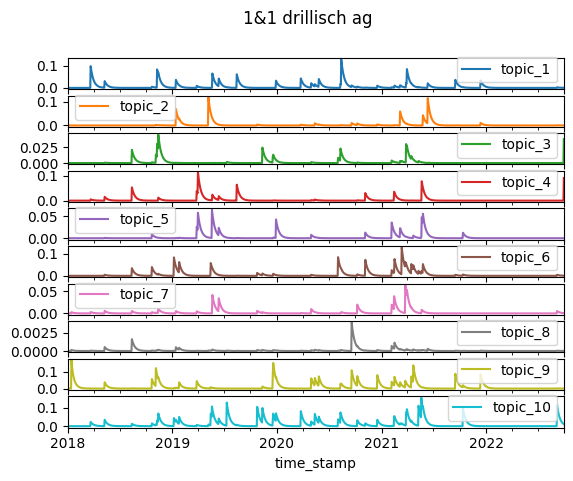

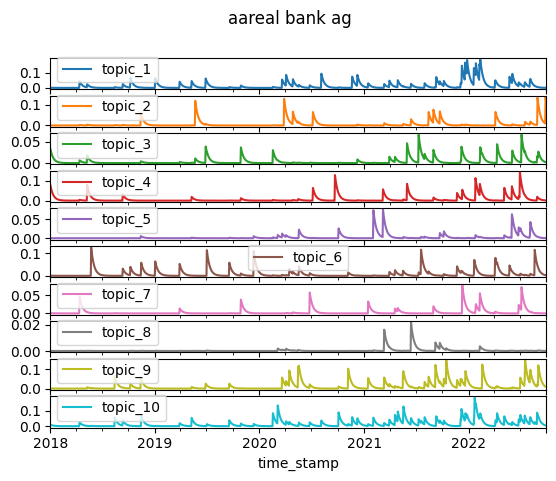

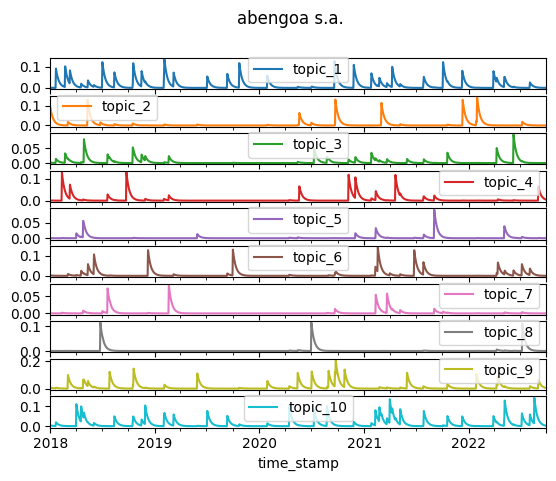

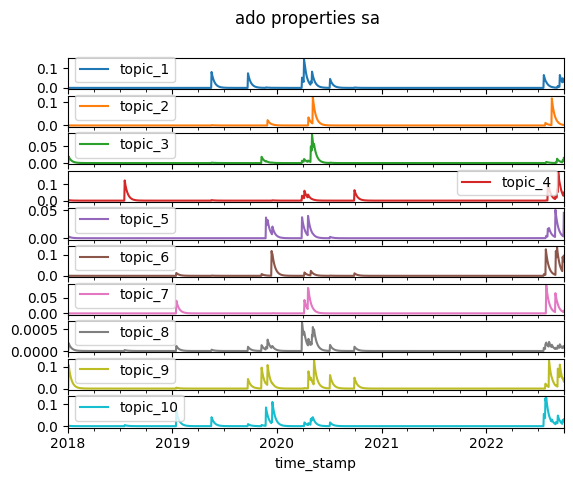

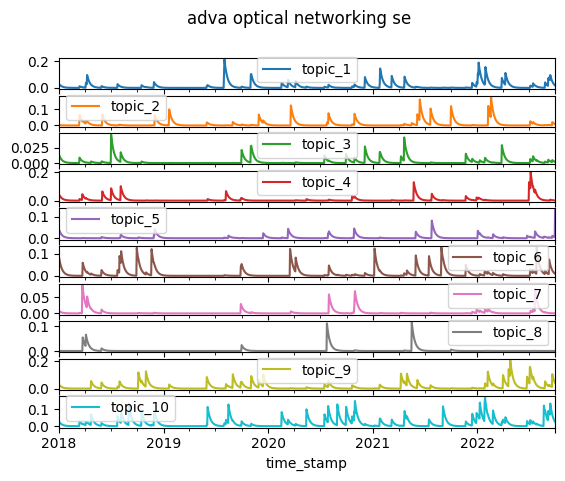

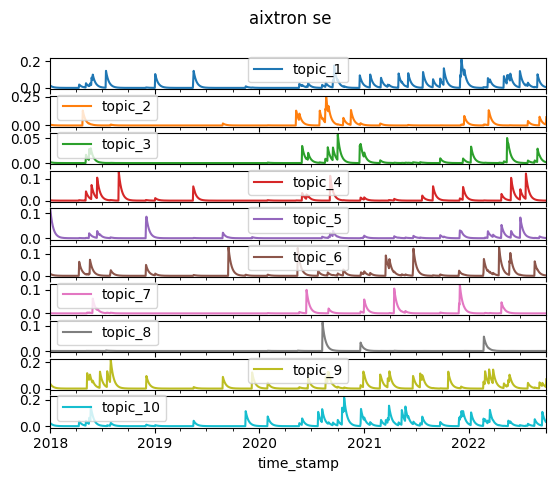

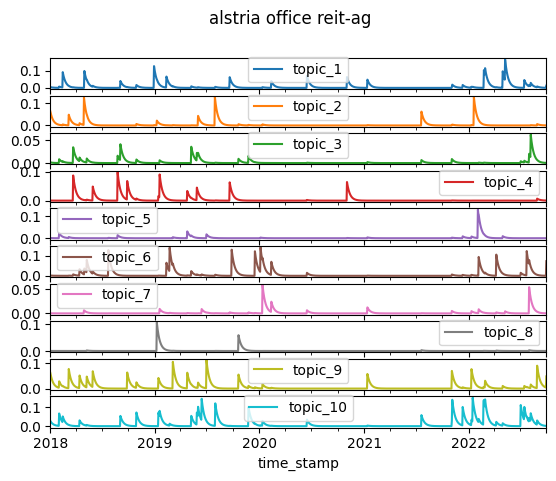

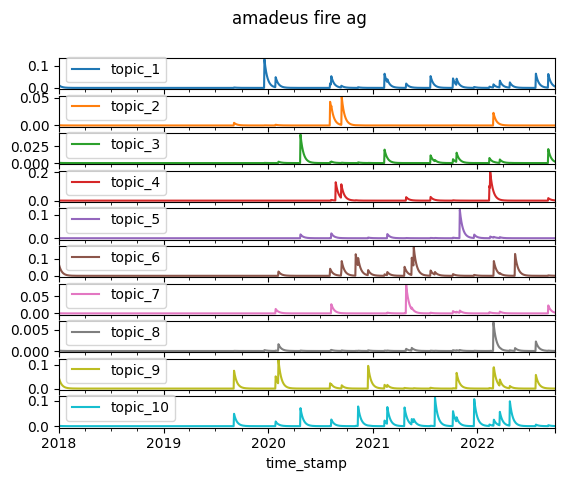

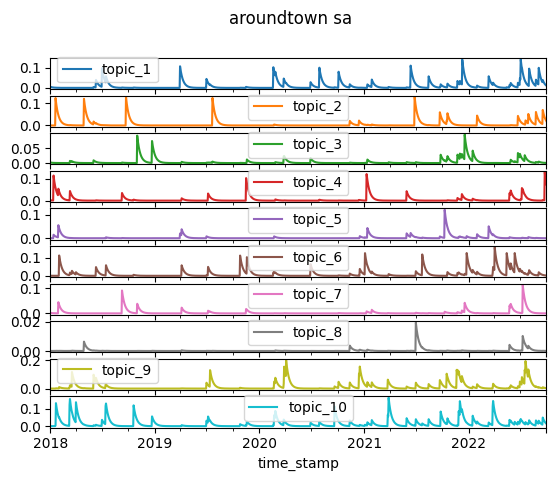

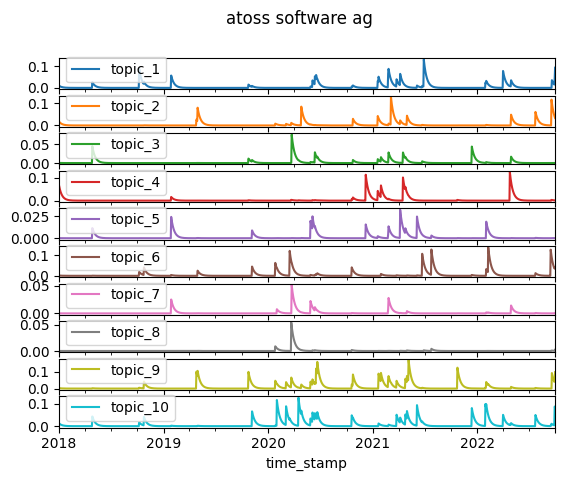

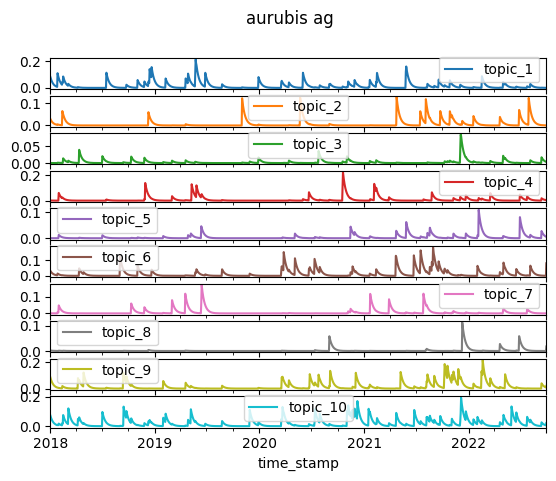

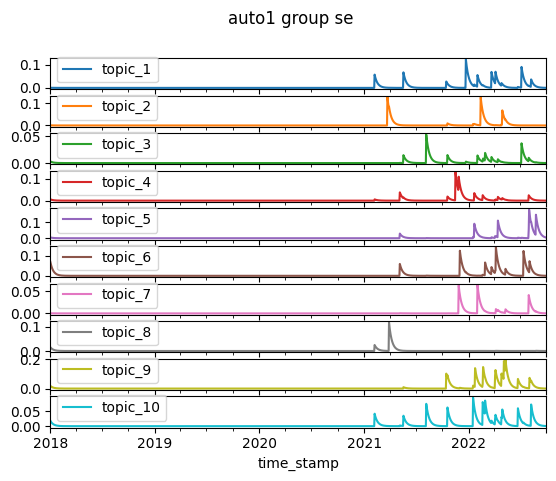

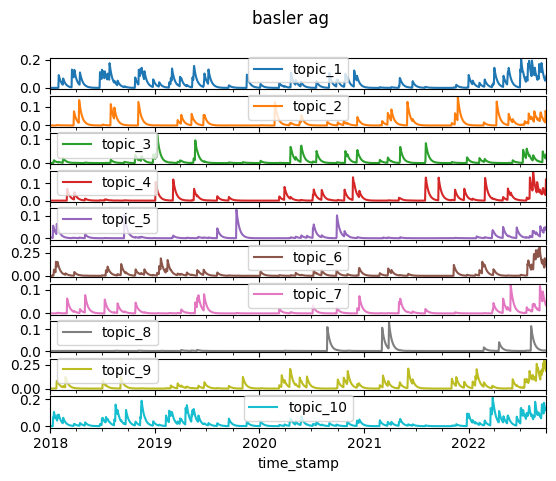

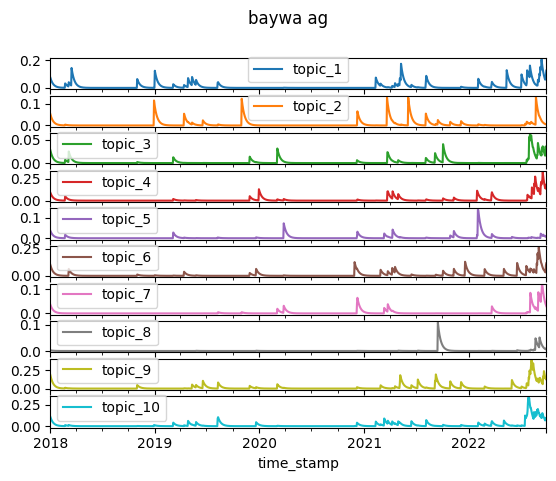

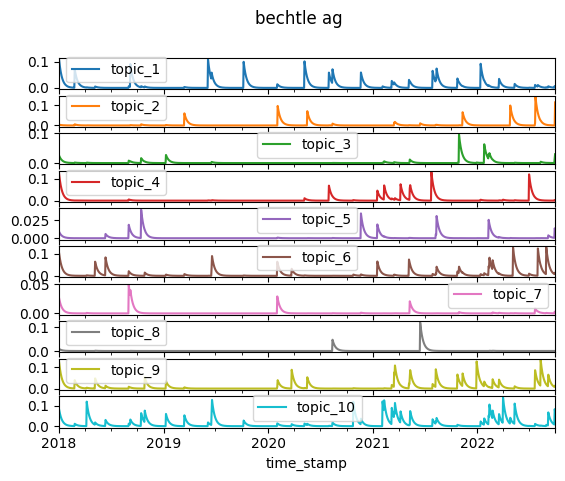

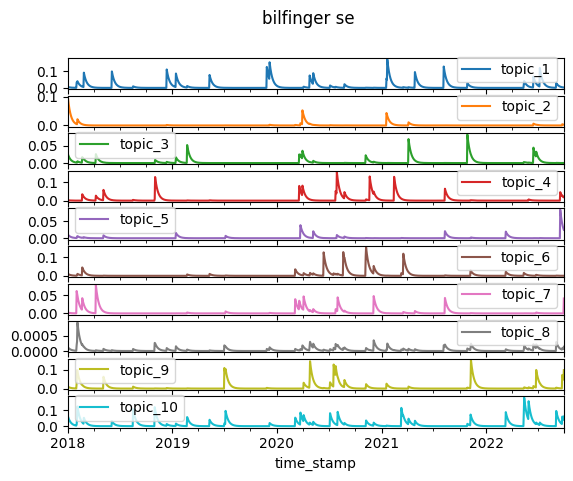

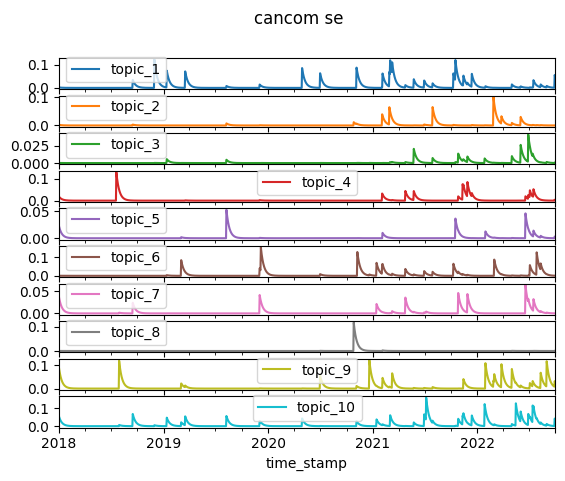

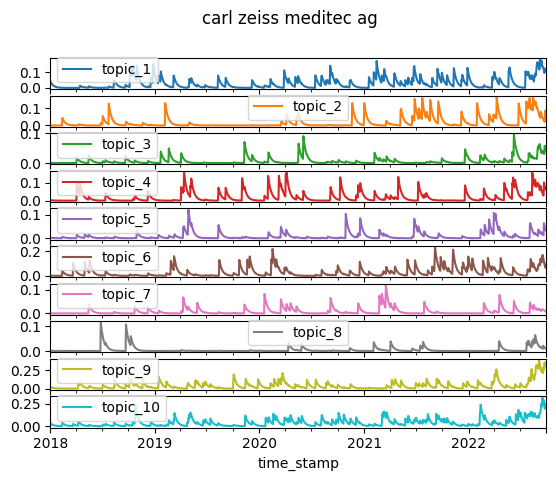

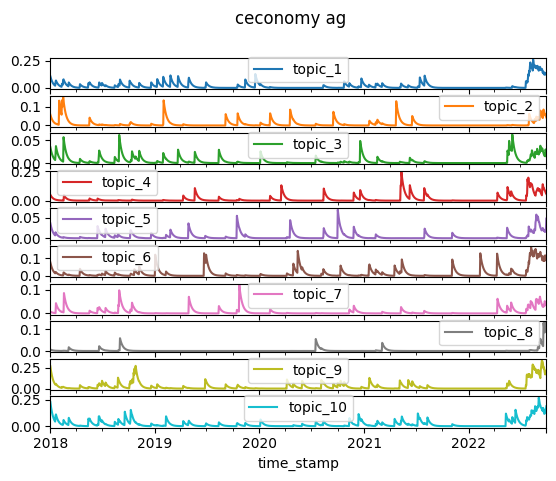

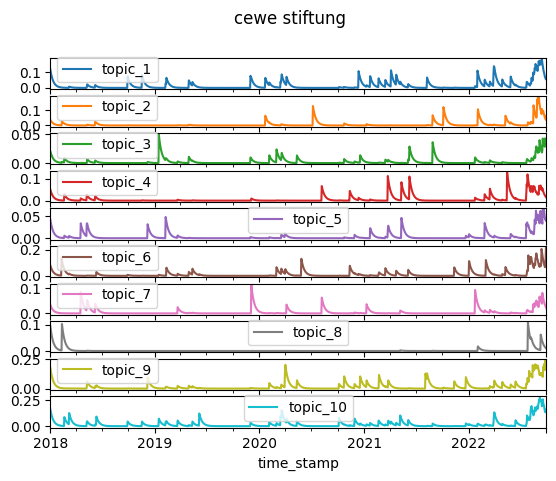

In [76]:
companys = sorted(list(set(topic_activity.index.get_level_values('company'))))

for i in range(20):
    topic_activity.loc[companys[i], :].plot(
        kind='line',
        title=companys[i],
        subplots=True
    )
    #plt.title(companys[i])
    plt.show()